GUERIOT Benjamin/GONAY Arthur | IDU4 | 11/2022 | Projet de modélisation stochastique(DATA731)

Depuis quelques années, nous avons pris conscience de l’importance de la végétation au sein des villes, c’est pour cela que nous avons décidé d’analyser l'évolution des espaces vert de Paris.
Ce projet consiste à repérer les zones de changements de végétations entre deux années pour les afficher sur une carte en niveau de gris afin de pouvoir clairement les observer.

Pour ce faire nous avons sélectionné grâce au programme d'observation LandSat, 4 images optiques de Paris sur différentes années (1987,2007,2011 et 2022). Il est important de noter qu'un filtre "vegetation index" a été appliqué directement depuis Landsat.

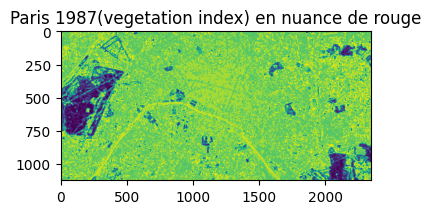

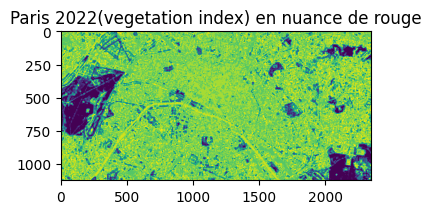

In [15]:
import imageio
from hashlib import new
from matplotlib import image, pyplot as plt
from matplotlib import image as mpimg
import numpy as np
 
 
paris1987 = mpimg.imread("paris_1987_10m.tif")[:,:,0]
paris2007 = mpimg.imread("paris_2007_10m.tif")[:,:,0]
paris2011 = mpimg.imread("paris_2011_10m.tif")[:,:,0]
paris2022 = mpimg.imread("paris_2022_10m.tif")[:,:,0]
parisBase = mpimg.imread("paris_2011_10m_base.tif")


plt.figure(figsize=(4,4))
plt.title("Paris 1987(vegetation index) en nuance de rouge")
plt.imshow(paris1987)
plt.show()

plt.figure(figsize=(4,4))
plt.title("Paris 2022(vegetation index) en nuance de rouge")
plt.imshow(paris2022)
plt.show()


Dans un premier temps on cherche à simplifier les images en la passant d'un codage RGB à un image en nuance de rouge. Comme on peut le voir ci-dessus, c'est bien le codage en nuance de rouge qui met le mieux en évidence les zones d'espaces vert, car ceux-ci sont caractérisé par l'absence presque total de cette couleur. Cela se traduit sur l'image par les zones sombres.

In [4]:
def mu(tab):
    return np.mean(tab)

def sigma(tab):
    return np.std(tab)

def imageAnalyse(image):
    finaltab=[]
    for line in range(0,len(image),3):
        newline=[]
        for column in range(0,len(image[0]),3):
            tab=[]
            for i in range(3):
                for j in range(3):
                    if line+i<len(image) and column+j<len(image[0]):
                        tab.append(image[line+i][column+j])
            data=(mu(tab),sigma(tab))
            newline.append(data)
        finaltab.append(newline) 

    return finaltab

print(imageAnalyse(paris2022)[0][0:10])

[(186.0, 0.0), (186.0, 0.0), (190.22222222222223, 7.899054483189432), (194.44444444444446, 9.441175904999113), (186.0, 0.0), (186.0, 0.0), (186.0, 0.0), (186.0, 0.0), (190.22222222222223, 7.899054483189432), (196.55555555555554, 9.441175904999113)]


On définit une foncion d'analyse d'image qui a pour rôle le calul de la moyenne(mu) et de l'écart type(sigma) sur des carrés de 3x3 pixels sur l'ensemble de l'image. On obtient un tableau de 2 dimensions (de taille de bordure 3 fois plus petite que l'image) contenant des tuples avec ces 2 informations.

Afin de montrer la forme générale du résultat nous avons affiché les 10 premières valeurs de la première ligne du tableau obtenue pour paris2022.

In [8]:
def entropieRelative(mu1,sigma1,mu2,sigma2):
    return ((1/2)*(mu1-mu2)**2*((1/sigma1**2)+(1/sigma2**2)))+((1/2)*(sigma1**2/sigma2**2)+(sigma2**2/sigma1**2))

def entropieRelativeImage(image1,image2):
    resfinal=[]
    for line in range(len(image1)):
        newline=[]
        for column in range(len(image1[0])):
            mu1=image1[line][column][0]
            sigma1=image1[line][column][1]+1
            mu2=image2[line][column][0]
            sigma2=image2[line][column][1]+1
            ER=entropieRelative(mu1,sigma1,mu2,sigma2)
            if ER<10000:
                newline.append(0)
            else:
                newline.append(ER)
        resfinal.append(newline)
    return resfinal

print(entropieRelativeImage(imageAnalyse(paris2022),imageAnalyse(paris1987))[100][100:200])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15377.5, 10202.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


On calcul ici l'entropie relative entre les mu/sigma de l'image de paris2022 et de paris1987 afin de repérer les potentiels changements sur la végétation.

Dans le résultat ci-dessus on affiche 100 valeurs prisent sur le tableau de l'entropie relative entre les deux images. On remarque qu'il y a principalement des 0. Cela correspond à des zones où il n'y a eu aucun changement sur la végétation. Au contraire, les 2 valeurs non nulles sont quant à elles le résultats de zones de changement de végétation (ajout ou supression).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


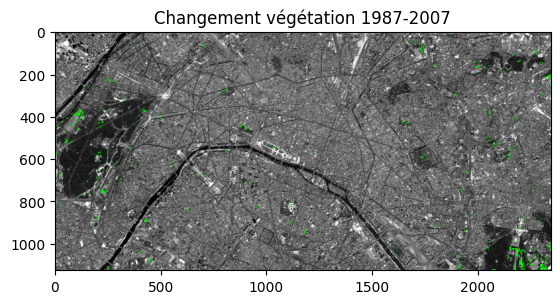

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


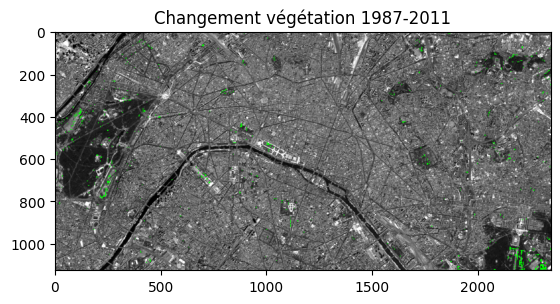

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


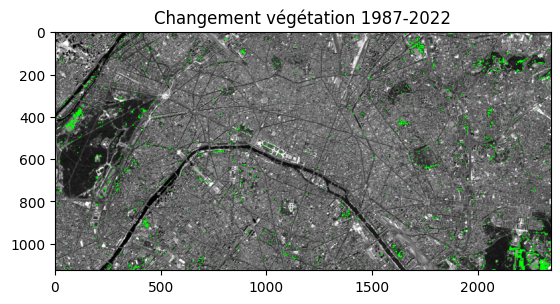

In [11]:
def displayParis(imageEvol,imageParis,titre):
    imageParisEvol=[]
    for line in range(len(imageParis)):
        newline=[]
        for column in range(len(imageParis[0])):
            if imageEvol[int(line/3)][int(column/3)]==0:
                newline.append([imageParis[line][column],imageParis[line][column],imageParis[line][column]])
            else:
                newline.append([0,256,0])
        imageParisEvol.append(newline)
    plt.figure()
    plt.title(titre)
    plt.imshow(imageParisEvol)
    plt.show()

displayParis(entropieRelativeImage(imageAnalyse(paris1987),imageAnalyse(paris2007)),parisBase,"Changement végétation 1987-2007")
displayParis(entropieRelativeImage(imageAnalyse(paris1987),imageAnalyse(paris2011)),parisBase,"Changement végétation 1987-2011")
displayParis(entropieRelativeImage(imageAnalyse(paris1987),imageAnalyse(paris2022)),parisBase,"Changement végétation 1987-2022")

Les images obtenues permettent d’observer de gros changements de végétation. Cependant, bien que la plupart de ces changements soient des ajouts, il y a potentielement aussi des zones de suppressions. En effet, notre analyse ne différencie pas ces deux cas de figures.

Avec une image de plus haute qualité, il nous serait possible de différencier la majorité des cas de suppression notamment par l’analyse de la forme des zones changements.